# Data Scraping

In this project, we aim to collect and analyze data from Booking.com and Expedia using Selenium. This tool allows us to simulate a web search and scrape the resulting data. Our search criteria are deliberately strict to ensure a fair comparison between the two platforms. Specifically, we will focus on the New York location and filter our search to include only five-star hotels. We will maintain default settings for other parameters, such as searching for one room accommodating two adults, with no children or additional requirements.

## Initialization

During the initialization phase, we import the necessary libraries and configure the Chrome driver, which will be the foundation for our web scraping efforts.


In [77]:
import os
import json
from selenium import webdriver
from datetime import datetime, timedelta
from booking import getBookingDataForCheckingInOut
from expedia import getExpediaDataForCheckingInOut
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

chromeDriverPath = "./driver/chromedriver"
chromeOptions = Options()
for arg in ["--no-sandbox", "--disable-dev-shm-usage"]:
    chromeOptions.add_argument(arg)

To gain meaningful insights and identify trends, we will scrape data for the entire month of October. Each night’s rate is treated independently, allowing us to analyze prices whether booked individually or as part of a multi-night stay. Thus, we will check rates for every night throughout the month. The scraping process relies primarily on class names to identify elements containing the desired information. We have implemented exception handling to manage situations where an element may be missing or return an unexpected value. Further data cleaning and validation will be conducted in subsequent stages.

The `collectDataForRange(range, isBooking)` function iterates over each day in the specified date range. The `isBooking` boolean flag determines whether to scrape data from Booking.com or Expedia. This function internally calls `getBookingDataForCheckingInOut` or `getExpediaDataForCheckingInOut` to gather data for each day, compiling the results into a list that is returned at the end.

The `getDataList(start, end, isBooking)` function calls `collectDataForRange` to scrape data for the specified range, provided that data has not already been collected and stored in a JSON file. If a corresponding file exists for the date range, the function parses the data from this file and returns the results.


In [78]:
def collectDataForRange(range, isBooking):
    dataList = []
    startDate, endDate = range

    while startDate < endDate:
        checkIn = startDate.strftime("%Y-%m-%d")
        checkOut = (startDate + timedelta(days=1)).strftime("%Y-%m-%d")
        service = Service(chromeDriverPath)
        driver = webdriver.Chrome(service=service, options=chromeOptions)
        try:

            data = (
                getBookingDataForCheckingInOut(driver, checkIn, checkOut)
                if isBooking
                else getExpediaDataForCheckingInOut(driver, checkIn, checkOut)
            )
            print(f"{len(data)} hotels available from {checkIn} to {checkOut}")
        except Exception:
            data = []
        driver.quit()
        dataList.extend(data)
        startDate += timedelta(days=1)
    return dataList


def getDataList(start, end, isBooking):
    pholder = "booking" if isBooking else "expedia"
    dataFile = f"{pholder}_{start.strftime('%Y-%m-%d')}_{end.strftime('%Y-%m-%d')}.json"
    if os.path.exists(dataFile):
        with open(dataFile, "r") as jsonFile:
            return json.load(jsonFile)
    else:
        comData = collectDataForRange((start, end), isBooking)
        with open(dataFile, "w") as jsonFile:
            json.dump(comData, jsonFile, indent=4)
        return comData

## Scraped Properties from Both Websites

For every search result, we capture a set of properties for each hotel that will be instrumental in our analysis. The properties collected include:

- **Name**: The name of the hotel.
- **Rating**: The hotel's star rating.
- **Review**: The text review of hotel (Good/Bad/Excellent).
- **Review Count**: The total number of reviews.
- **Selling Price**: The price at which the room is currently being offered (in ₹).
- **Cost Price**: The original price before any discounts (in ₹).
- **Taxes**: Any applicable taxes on the booking.
- **Rooms Left**: The number of available rooms in case limited quantity available.
- **Check-In Date**: The check-in date for the booking.
- **Check-Out Date**: The check-out date for the booking.
- **Refundable**: A boolean indicating whether the booking is refundable.
- **Reservable**: A boolean indicating whether the room can be reserved without immediate payment.
- **Breakfast Included**: A boolean indicating whether breakfast is included in the booking.
- **Amenities**: A list of amenities offered by the hotel.

By collecting these properties, we will have a comprehensive dataset that will facilitate in-depth analysis and comparison between the two booking platforms.


In [79]:
start, end = datetime(2024, 10, 1), datetime(2024, 10, 31)
bookingData = getDataList(start, end, isBooking=True)
expediaData = getDataList(start, end, isBooking=False)

## Data Cleaning Process

Data cleaning is essential for preparing our scraped data for analysis. We began by handling missing values by replacing instances of the string `'None'` with `NaN` to facilitate numerical analysis. Next, we converted key columns such as `rating`, `reviewCount`, `sellingPrice`, `costPrice`, and `taxes` to numeric types while removing commas as needed. Additionally, we transformed the `checkIn` and `checkOut` columns into datetime. Further analysing if there are duplicates and Na values. These cleaning steps ensure our dataset is accurate, consistent, and ready for analysis, allowing for reliable insights from the data.


In [80]:
import pandas as pd

bookingDf = pd.DataFrame(bookingData)
bookingDf.replace("None", pd.NA, inplace=True)
bookingDf["rating"] = pd.to_numeric(bookingDf["rating"], errors="coerce")
bookingDf["reviewCount"] = pd.to_numeric(bookingDf["reviewCount"], errors="coerce")
bookingDf["sellingPrice"] = bookingDf["sellingPrice"].str.replace(",", "").astype(float)
bookingDf["costPrice"] = bookingDf["costPrice"].str.replace(",", "").astype(float)
bookingDf["taxes"] = bookingDf["taxes"].str.replace(",", "").astype(float)
bookingDf["roomsLeft"] = pd.to_numeric(bookingDf["roomsLeft"], errors="coerce")
bookingDf["checkIn"] = pd.to_datetime(bookingDf["checkIn"])
bookingDf["checkOut"] = pd.to_datetime(bookingDf["checkOut"])
bookingDf = bookingDf[~bookingDf.drop(columns=["amenities"]).duplicated(keep="first")]

expediaDf = pd.DataFrame(expediaData)
expediaDf.replace("None", pd.NA, inplace=True)
expediaDf["rating"] = pd.to_numeric(expediaDf["rating"], errors="coerce")
expediaDf["reviewCount"] = pd.to_numeric(expediaDf["reviewCount"], errors="coerce")
expediaDf["sellingPrice"] = expediaDf["sellingPrice"].str.replace(",", "")
expediaDf["sellingPrice"] = pd.to_numeric(expediaDf["sellingPrice"], errors="coerce")
expediaDf["costPrice"] = expediaDf["costPrice"].str.replace(",", "")
expediaDf["costPrice"] = pd.to_numeric(expediaDf["costPrice"], errors="coerce")
expediaDf["taxes"] = expediaDf["taxes"]
expediaDf["roomsLeft"] = pd.to_numeric(expediaDf["roomsLeft"], errors="coerce")
expediaDf["checkIn"] = pd.to_datetime(expediaDf["checkIn"])
expediaDf["checkOut"] = pd.to_datetime(expediaDf["checkOut"])
expediaDf = expediaDf[~expediaDf.drop(columns=["amenities"]).duplicated(keep="first")]

In this cell, we perform fuzzy matching to identify corresponding hotel names between two datasets: Expedia and Booking.com. The goal is to create a mapping that associates similar hotel names from each dataset, allowing for a more comprehensive analysis of hotel availability and pricing.


In [81]:
import numpy as np
from fuzzywuzzy import process

unique_expedia_names = expediaDf["name"].unique()
unique_booking_names = bookingDf["name"].unique()
expedia_only_names = np.setdiff1d(unique_expedia_names, unique_booking_names)
booking_only_names = np.setdiff1d(unique_booking_names, unique_expedia_names)

mapping = {"Equinox Hotel New York": "Equinox Hotel Hudson Yards New York City"}

for name in expedia_only_names:
    match, score = process.extractOne(name, booking_only_names)
    if score >= 90:
        mapping[name] = match

expediaDf["name"] = expediaDf["name"].replace(mapping)

for expedia_name, booking_name in mapping.items():
    print(f"{expedia_name} -> {booking_name}")

Equinox Hotel New York -> Equinox Hotel Hudson Yards New York City
Hotel Barriere Fouquet's New York -> Hotel Barrière Fouquet's New York
InterContinental New York Barclay, an IHG Hotel -> InterContinental New York Barclay Hotel, an IHG Hotel
Refinery Hotel -> Refinery Hotel - New York
The Chatwal, In The Unbound Collection By Hyatt -> The Chatwal, The Unbound Collection by Hyatt
The Dominick -> The Dominick Hotel
The Knickerbocker Hotel -> The Knickerbocker
The Mark -> The Mark New York
The Plaza - A Fairmont Managed Hotel -> The Plaza
The Times Square EDITION -> The Times Square EDITION New York
The Towers at Lotte New York Palace -> Lotte New York Palace
The Wall Street Hotel -> The Wall Street Hotel New York City
WestHouse New York -> WestHouse Hotel New York


In [82]:
unique_expedia_names = expediaDf["name"].unique()
unique_booking_names = bookingDf["name"].unique()
expedia_only_names = np.setdiff1d(unique_expedia_names, unique_booking_names)
booking_only_names = np.setdiff1d(unique_booking_names, unique_expedia_names)

print("Expedia Only names")
print(expedia_only_names)

print("\nBooking Only names")
print(booking_only_names)

Expedia Only names
['1 Hotel Brooklyn Bridge' '5th & 55th Residence Club'
 'Hilton Club The Quin New York'
 'InterContinental New York Times Square, an IHG Hotel'
 'Loews Regency New York Hotel' 'Nine Orchard'
 'The Carlyle, A Rosewood Hotel' 'The Lowell'
 'The Opus Westchester, Autograph Collection' 'The William Vale'
 'Trump International Hotel & Tower New York'
 'Virgin Hotels New York City']

Booking Only names
['Collective Governors Island' 'Crosby Street Hotel'
 'Iroquois New York Times Square' 'JW Marriott Essex House New York'
 'Kimpton Hotel Eventi, an IHG Hotel' 'Kimpton Hotel Theta, an IHG Hotel'
 'Le Meridien New York, Central Park by Marriott' 'Lowell Hotel'
 'ModernHaus SoHo' 'New York Marriott Marquis' 'Park Lane New York'
 'The Benjamin Royal Sonesta New York' 'The Bowery Hotel'
 'The Evelyn NoMad' 'The Frederick Hotel Tribeca' 'The Greenwich Hotel'
 'The Mercer' 'The Sherry Netherland' 'The Wallace Hotel'
 'The Westin New York at Times Square' 'The Whitby Hotel'
 'Thom

## Price Comparison

Comparing prices between Booking.com and Expedia involves more than just looking at the listed prices; we must also consider the cost price, discounted price, and applicable taxes. To ensure a fair comparison, we focused only on hotels listed on both platforms. This allows us to evaluate the average pricing for these common hotels over the course of a month and analyze the price distribution.


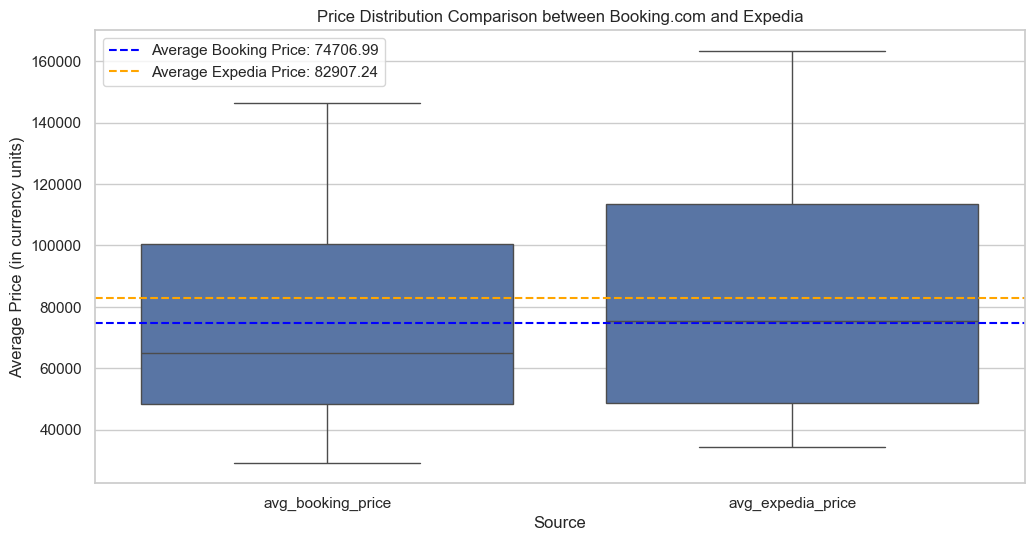

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

avg_booking_prices = bookingDf.groupby("name")["sellingPrice"].mean().reset_index()
avg_booking_prices.rename(columns={"sellingPrice": "avg_booking_price"}, inplace=True)
avg_expedia_prices = expediaDf.groupby("name")["sellingPrice"].mean().reset_index()
avg_expedia_prices.rename(columns={"sellingPrice": "avg_expedia_price"}, inplace=True)
price_comp_df = pd.merge(avg_booking_prices, avg_expedia_prices, on="name", how="outer")
diff = price_comp_df["avg_booking_price"] - price_comp_df["avg_expedia_price"]
price_comp_df["price_difference"] = diff

sns.set(style="whitegrid")
melted_df = price_comp_df.melt(
    id_vars="name",
    value_vars=["avg_booking_price", "avg_expedia_price"],
    var_name="Source",
    value_name="Average Price",
)
plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x="Source", y="Average Price", data=melted_df)
avg_booking_price = bookingDf["sellingPrice"].mean()
avg_expedia_price = expediaDf["sellingPrice"].mean()
plt.axhline(
    avg_booking_price,
    color="blue",
    linestyle="--",
    label=f"Average Booking Price: {avg_booking_price:.2f}",
)
plt.axhline(
    avg_expedia_price,
    color="orange",
    linestyle="--",
    label=f"Average Expedia Price: {avg_expedia_price:.2f}",
)
plt.title("Price Distribution Comparison between Booking.com and Expedia")
plt.ylabel("Average Price (in currency units)")
plt.xlabel("Source")
plt.legend()
plt.show()

From the analysis, it is evident that Booking.com is more cost-effective at every level. The median price on Booking.com is approximately 8,000 lower than that of Expedia. Furthermore, even when including all hotel listings—both common and unique—the average price on Expedia remains over 8,000 higher than on Booking.com.

### Taxes


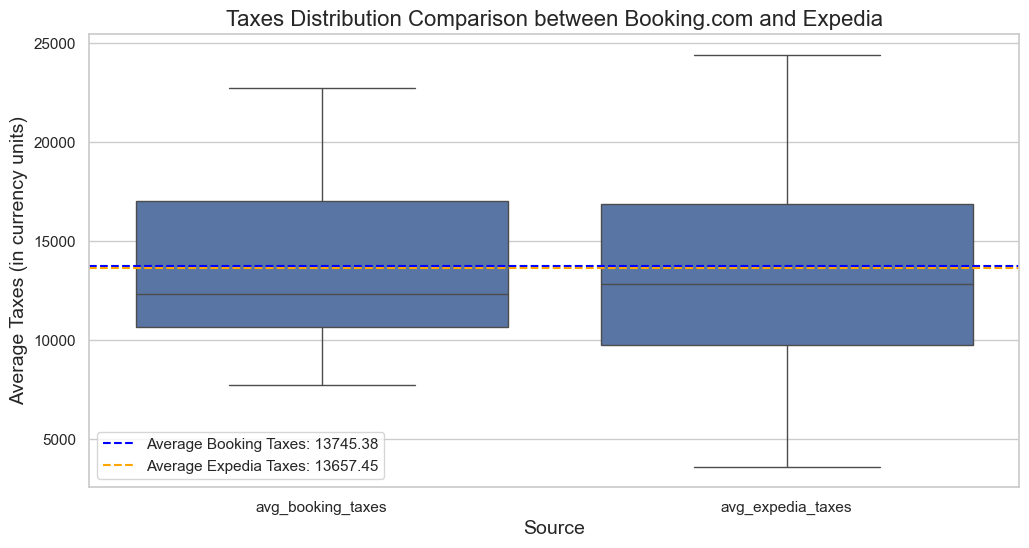

In [84]:
avg_booking_taxes = bookingDf.groupby("name")["taxes"].mean().reset_index()
avg_booking_taxes.rename(columns={"taxes": "avg_booking_taxes"}, inplace=True)
avg_expedia_taxes = expediaDf.groupby("name")["taxes"].mean().reset_index()
avg_expedia_taxes.rename(columns={"taxes": "avg_expedia_taxes"}, inplace=True)
taxes_comp_df = pd.merge(avg_booking_taxes, avg_expedia_taxes, on="name", how="outer")

melted_tax_df = taxes_comp_df.melt(
    id_vars="name",
    value_vars=["avg_booking_taxes", "avg_expedia_taxes"],
    var_name="Source",
    value_name="Average Taxes",
)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x="Source", y="Average Taxes", data=melted_tax_df)

avg_booking_taxes_value = bookingDf["taxes"].mean()
avg_expedia_taxes_value = expediaDf["taxes"].mean()

plt.axhline(
    avg_booking_taxes_value,
    color="blue",
    linestyle="--",
    label=f"Average Booking Taxes: {avg_booking_taxes_value:.2f}",
)
plt.axhline(
    avg_expedia_taxes_value,
    color="orange",
    linestyle="--",
    label=f"Average Expedia Taxes: {avg_expedia_taxes_value:.2f}",
)

plt.title("Taxes Distribution Comparison between Booking.com and Expedia", fontsize=16)
plt.ylabel("Average Taxes (in currency units)", fontsize=14)
plt.xlabel("Source", fontsize=14)
plt.legend()
plt.show()

The tax rates on both platforms appear to be comparable, with averages around 13,500. Although Booking.com generally offers lower selling prices, the tax amounts are similar. This is likely because the taxes are based on a fixed percentage or duty that the aggregator must pay at the time of booking.

### Discounts


In [85]:
from tabulate import tabulate

bookingDf["discount_percentage"] = (
    (bookingDf["costPrice"] - bookingDf["sellingPrice"]) / bookingDf["costPrice"] * 100
).fillna(0)

expediaDf["discount_percentage"] = (
    (expediaDf["costPrice"] - expediaDf["sellingPrice"]) / expediaDf["costPrice"] * 100
).fillna(0)

average_booking_discount = bookingDf["discount_percentage"].mean()
average_expedia_discount = expediaDf["discount_percentage"].mean()
booking_discount_count = (bookingDf["discount_percentage"] > 0).sum()
expedia_discount_count = (expediaDf["discount_percentage"] > 0).sum()

total_booking_listings = len(bookingDf)
total_expedia_listings = len(expediaDf)

percentage_booking_with_discount = (
    booking_discount_count / total_booking_listings
) * 100
percentage_expedia_with_discount = (
    expedia_discount_count / total_expedia_listings
) * 100
summary = {
    "Platform": ["Booking.com", "Expedia"],
    "Average Discount Percentage": [average_booking_discount, average_expedia_discount],
    "Percentage of Listings with Discount": [
        percentage_booking_with_discount,
        percentage_expedia_with_discount,
    ],
}

summary_df = pd.DataFrame(summary)
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

+----+-------------+-------------------------------+----------------------------------------+
|    | Platform    |   Average Discount Percentage |   Percentage of Listings with Discount |
+====+=============+===============================+========================================+
|  0 | Booking.com |                      0.837541 |                                7.14286 |
+----+-------------+-------------------------------+----------------------------------------+
|  1 | Expedia     |                      4.19843  |                               30.0503  |
+----+-------------+-------------------------------+----------------------------------------+


When it comes to discounts, Expedia offers discounts on approximately 30% of its listings compared to only 7% on Booking.com. Despite this, Expedia’s average selling price is still around 8,000 higher than Booking.com’s. Moreover, the average discount percentage on Expedia is nearly five times greater than that of Booking.com (0.8%). This suggests that while Expedia promotes more discounts, it compensates by inflating its cost prices to maintain higher selling prices.


# Which hotel listing site offers better rates?

Booking.com offers better rates than Expedia, as evidenced by a consistently lower average selling price—approximately 8,000 lower—and a median price that reflects the same trend. While Expedia advertises discounts on about 30% of its listings, the selling price is still significantly higher than that of Booking.com. Overall, the analysis suggests that Booking.com is the more cost-effective choice for hotel listings.


## Inventory Comparison

In our inventory comparison, we analyze several key aspects of hotel listings, such as the number of listings available per search request, important amenities highlighted, and a comparison of ratings and reviews on both platforms. This helps provide a comprehensive view of the options and quality offered by Booking.com and Expedia.

### Number of Listings per Search Request

This metric gives insight into how many options each website offers per search query. More options generally mean a better chance of finding a suitable hotel.


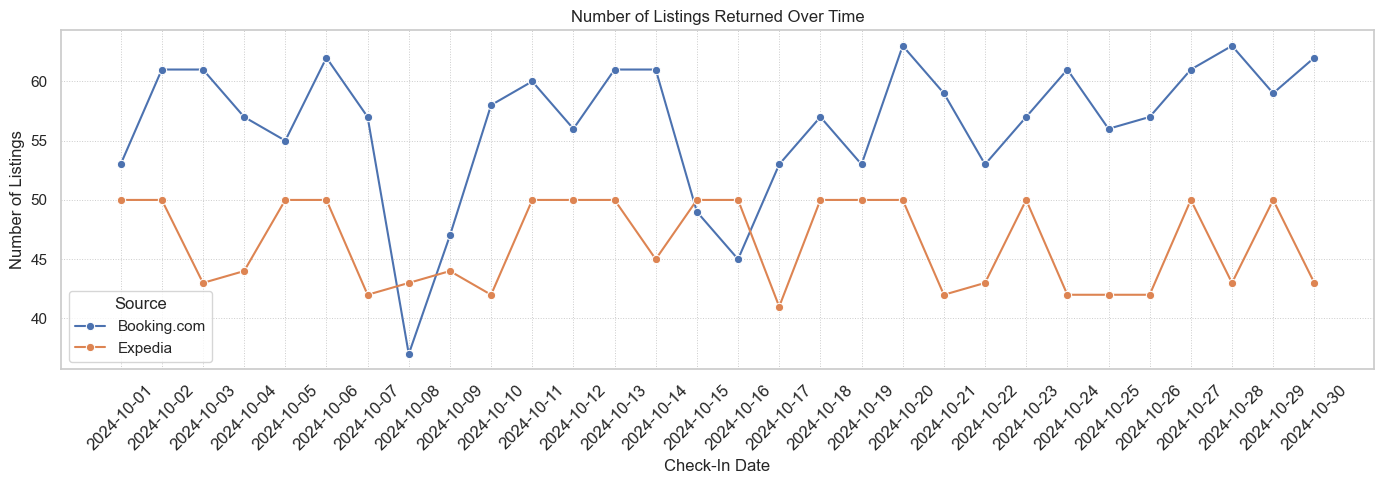

+-------------+--------------------+----------------------------+
| Source      |   Average Listings |   Unavailable Listings (%) |
+=============+====================+============================+
| Booking.com |            56.4667 |                     0      |
+-------------+--------------------+----------------------------+
| Expedia     |            46.3667 |                     6.1826 |
+-------------+--------------------+----------------------------+


In [66]:
def count_listings_per_day(df, source):
    listings_count = df.groupby("checkIn").size().reset_index(name="Listings")
    listings_count["Source"] = source
    return listings_count


booking_counts = count_listings_per_day(bookingDf, "Booking.com")
expedia_counts = count_listings_per_day(expediaDf, "Expedia")
combined_counts = pd.concat([booking_counts, expedia_counts])

plt.figure(figsize=(14, 5), dpi=100)
sns.lineplot(data=combined_counts, x="checkIn", y="Listings", hue="Source", marker="o")
plt.title("Number of Listings Returned Over Time")
plt.xlabel("Check-In Date")
plt.xticks(
    pd.date_range(
        start=combined_counts["checkIn"].min(),
        end=combined_counts["checkIn"].max(),
        freq="D",
    ),
    rotation=45,
    fontsize=12,
)
plt.ylabel("Number of Listings")
plt.grid()
plt.legend(title="Source")
plt.tight_layout()
plt.grid(visible=True, linestyle=":", linewidth=0.7)
plt.show()

booking_up = (bookingDf["sellingPrice"].isna().sum() / len(bookingDf)) * 100
expedia_up = (expediaDf["sellingPrice"].isna().sum() / len(expediaDf)) * 100
overall_average = combined_counts.groupby("Source")["Listings"].mean().reset_index()
overall_average.rename(columns={"Listings": "Average Listings"}, inplace=True)

summary_data = {
    "Source": ["Booking.com", "Expedia"],
    "Average Listings": [
        overall_average.loc[
            overall_average["Source"] == "Booking.com", "Average Listings"
        ].values[0],
        overall_average.loc[
            overall_average["Source"] == "Expedia", "Average Listings"
        ].values[0],
    ],
    "Unavailable Listings (%)": [booking_up, expedia_up],
}

summary_df = pd.DataFrame(summary_data)
print(tabulate(summary_df, headers="keys", tablefmt="grid", showindex=False))

From the data, Booking.com returns an average of 56 listings per search, while Expedia offers about 46, which is nearly 20% fewer. Additionally, Booking.com doesn't display unavailable listings, while Expedia does, with around 6% of listings being unavailable to book. This highlights that Booking.com might provide a more seamless experience with fewer irrelevant listings shown.

### Amenities

Both platforms do an excellent job of highlighting important amenities like refundable options, reservable (pay later), and breakfast included. These are key factors that can influence booking decisions. Minor amenities like pools, hot tubs, or proximity to public transit are also included but vary across platforms.


In [47]:
booking_refundable_percentage = (bookingDf["refundable"].sum() / len(bookingDf)) * 100
booking_reservable_percentage = (bookingDf["reservable"].sum() / len(bookingDf)) * 100
booking_breakfast_percentage = (bookingDf["breakfast"].sum() / len(bookingDf)) * 100
booking_rl_percent = (bookingDf["roomsLeft"] > 0).sum() / len(bookingDf) * 100
expedia_refundable_percentage = (expediaDf["refundable"].sum() / len(expediaDf)) * 100
expedia_reservable_percentage = (expediaDf["reservable"].sum() / len(expediaDf)) * 100
expedia_breakfast_percentage = (expediaDf["breakfast"].sum() / len(expediaDf)) * 100
expedia_rl_percent = (expediaDf["roomsLeft"] > 0).sum() / len(expediaDf) * 100

options_summary_data = {
    "Source": ["Booking.com", "Expedia"],
    "Refundable (%)": [booking_refundable_percentage, expedia_refundable_percentage],
    "Reservable (%)": [booking_reservable_percentage, expedia_reservable_percentage],
    "Breakfast (%)": [booking_breakfast_percentage, expedia_breakfast_percentage],
    "Rooms Left Above 0 (%)": [booking_rl_percent, expedia_rl_percent],
}

options_summary_df = pd.DataFrame(options_summary_data)
print(tabulate(options_summary_df, headers="keys", tablefmt="grid", showindex=False))

+-------------+------------------+------------------+-----------------+--------------------------+
| Source      |   Refundable (%) |   Reservable (%) |   Breakfast (%) |   Rooms Left Above 0 (%) |
+=============+==================+==================+=================+==========================+
| Booking.com |          45.4545 |          17.7686 |         6.49351 |                  18.536  |
+-------------+------------------+------------------+-----------------+--------------------------+
| Expedia     |          54.9964 |          40.6902 |         3.95399 |                  49.1014 |
+-------------+------------------+------------------+-----------------+--------------------------+


Expedia excels in offering reservable listings, with 41% of listings allowing you to pay later, compared to just 18% on Booking.com. Similarly, Expedia has refundable options on 55% of listings, while Booking.com offers them on 45%.
In contrast, Booking.com offers breakfast inclusion on 6.5% of its listings compared to Expedia's 4%.
Room left availability is shown in about 50% of Expedia listings, creating a sense of urgency, while Booking.com only shows this in 19% of cases.
Overall, Expedia offers more convenience in terms of flexibility (pay later, refundable options), but Booking.com provides better availability of amenities like breakfast.

### Services Offered

When comparing other amenities, Booking.com tends to focus more on convenience factors like proximity to public transit and attractions, while Expedia highlights in-property services like pools and hot tubs. The two platforms offer different amenities, appealing to different types of travelers.

### Review and ratings

To evaluate the likelihood of finding a "good" hotel, we consider both ratings and the number of reviews. High ratings alone can be misleading—it's the combination of ratings and a large number of reviews that paints a fuller picture.
Expedia appears to have more rigid rating intervals, typically in increments of 0.2, while Booking.com uses a more granular scale of 0.1 intervals.
Although both Booking.com and Expedia use similar rating intervals for hotel reviews, their categories can be roughly segmented as follows: a rating below 7.0 is considered Poor, 7.0-8.0 is Good, 8.0-8.5 is Very Good, 8.5-9.0 is Excellent, 9.0-9.5 is Wonderful, and anything above 9.5 is Exceptional.


In [55]:
bookingDf[["review", "rating"]].drop_duplicates().sort_values("rating").reset_index(
    drop=["index"]
)

,review,rating
0,Review score,6.9
1,Good,7.4
2,Good,7.5
3,Good,7.6
4,Good,7.7
5,Good,7.8
6,Good,7.9
7,Very Good,8.0
8,Very Good,8.1
9,Very Good,8.2


In [56]:
expediaDf[["review", "rating"]].drop_duplicates().sort_values("rating").reset_index(
    drop=["index"]
)

,review,rating
0,Good,7.4
1,Very good,8.0
2,Very good,8.4
3,Excellent,8.6
4,Excellent,8.8
5,Wonderful,9.0
6,Wonderful,9.2
7,Exceptional,9.4
8,Exceptional,9.6
9,Exceptional,9.8


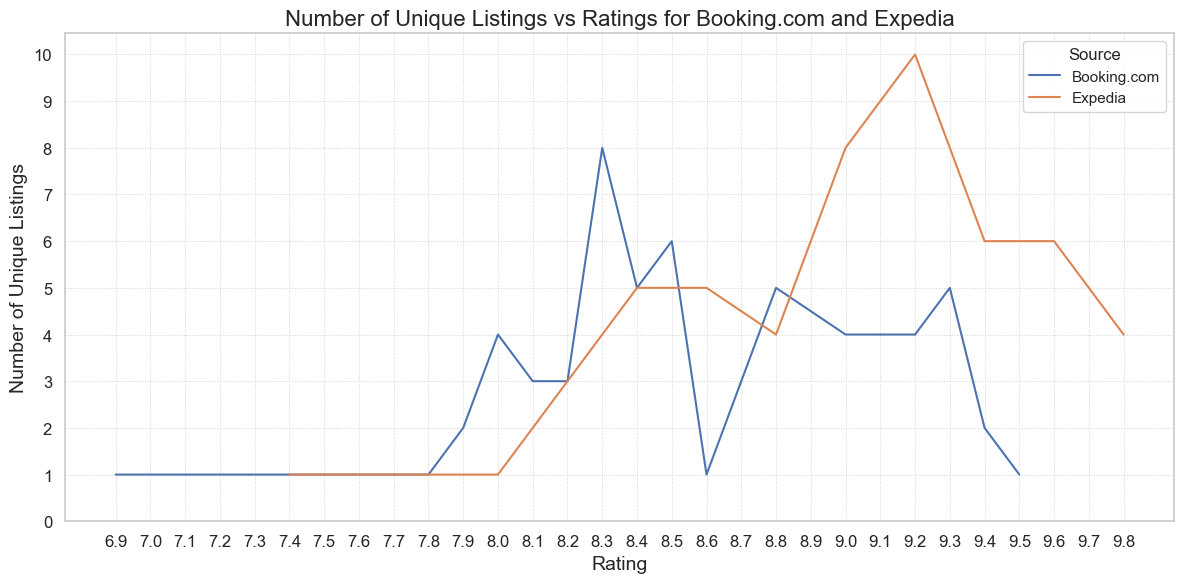

In [73]:
booking_unique = bookingDf.drop_duplicates(subset="name")
expedia_unique = expediaDf.drop_duplicates(subset="name")

booking_r = booking_unique.groupby("rating").size().reset_index(name="Listing Count")
booking_r["Source"] = "Booking.com"
expedia_r = expedia_unique.groupby("rating").size().reset_index(name="Listing Count")
expedia_r["Source"] = "Expedia"
combined_r = pd.concat([booking_r, expedia_r])

plt.figure(figsize=(12, 6), dpi=100)
sns.lineplot(data=combined_r, x="rating", y="Listing Count", hue="Source", marker="o")
plt.title("Number of Unique Listings vs Ratings", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Number of Unique Listings", fontsize=14)
plt.xticks(
    ticks=np.arange(combined_r["rating"].min(), combined_r["rating"].max() + 0.1, 0.1),
    fontsize=12,
)
plt.yticks(ticks=np.arange(0, combined_r["Listing Count"].max() + 1, 1), fontsize=12)
plt.grid(True, which="both", linestyle=":", linewidth=0.7, color="lightgray")
plt.tight_layout()
plt.show()

When comparing the same hotel listings across platforms, hotels on Expedia tend to have slightly higher ratings than on Booking.com. This could be due to user bias or Expedia's rating algorithm.


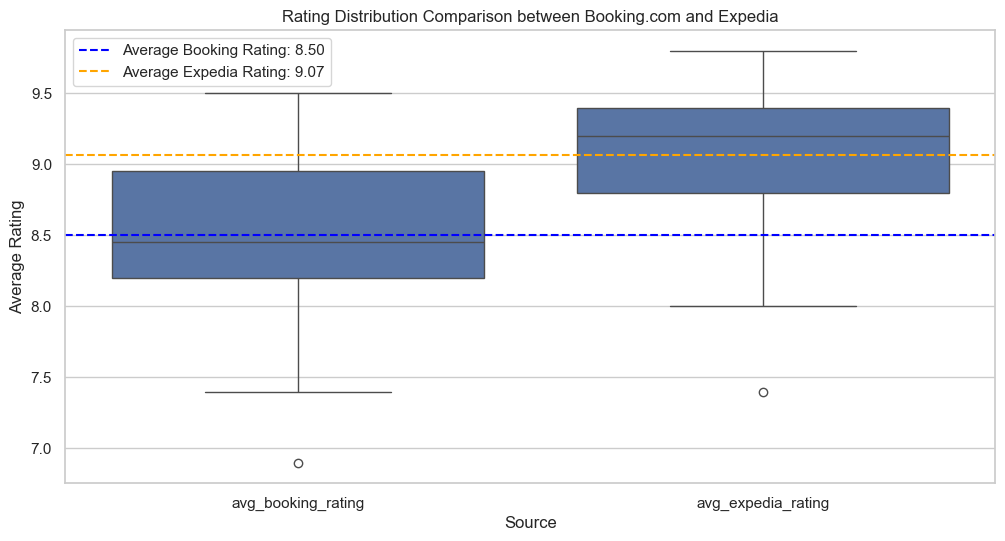

In [74]:
avg_booking_ratings = bookingDf.groupby("name")["rating"].mean().reset_index()
avg_booking_ratings.rename(columns={"rating": "avg_booking_rating"}, inplace=True)
avg_expedia_ratings = expediaDf.groupby("name")["rating"].mean().reset_index()
avg_expedia_ratings.rename(columns={"rating": "avg_expedia_rating"}, inplace=True)

rating_comp_df = pd.merge(
    avg_booking_ratings, avg_expedia_ratings, on="name", how="outer"
)
rating_diff = (
    rating_comp_df["avg_booking_rating"] - rating_comp_df["avg_expedia_rating"]
)
rating_comp_df["rating_difference"] = rating_diff

melted_ratings_df = rating_comp_df.melt(
    id_vars="name",
    value_vars=["avg_booking_rating", "avg_expedia_rating"],
    var_name="Source",
    value_name="Average Rating",
)


plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x="Source", y="Average Rating", data=melted_ratings_df)

avg_booking_rating = bookingDf["rating"].mean()
avg_expedia_rating = expediaDf["rating"].mean()

plt.axhline(
    avg_booking_rating,
    color="blue",
    linestyle="--",
    label=f"Average Booking Rating: {avg_booking_rating:.2f}",
)
plt.axhline(
    avg_expedia_rating,
    color="orange",
    linestyle="--",
    label=f"Average Expedia Rating: {avg_expedia_rating:.2f}",
)

plt.title("Rating Distribution Comparison between Booking.com and Expedia")
plt.ylabel("Average Rating")
plt.xlabel("Source")
plt.legend()
plt.show()

Looking at the overall rating distribution, Expedia hotels are rated on average about 0.5 points higher than their counterparts on Booking.com. Despite this, both platforms have a similar number of reviews per listing (around 320–330), with Expedia having slightly more. This greater review count gives Expedia a slight edge in user confidence, as more reviews suggest more customer feedback and experience.


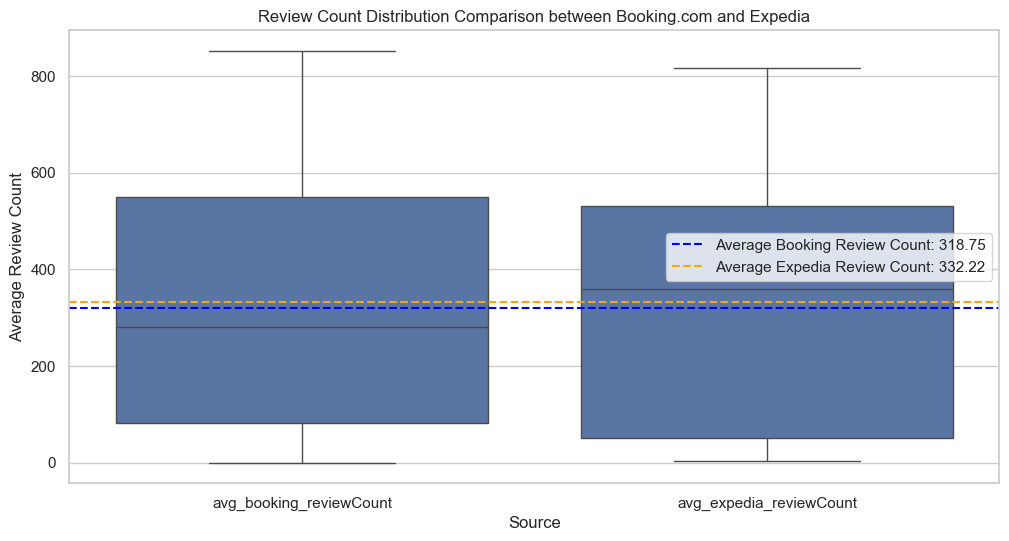

In [76]:
avg_booking_r = bookingDf.groupby("name")["reviewCount"].mean().reset_index()
avg_booking_r.rename(columns={"reviewCount": "avg_booking_reviewCount"}, inplace=True)
avg_expedia_r = expediaDf.groupby("name")["reviewCount"].mean().reset_index()
avg_expedia_r.rename(columns={"reviewCount": "avg_expedia_reviewCount"}, inplace=True)
review_comp_df = pd.merge(avg_booking_r, avg_expedia_r, on="name", how="outer")

review_diff = (
    review_comp_df["avg_booking_reviewCount"]
    - review_comp_df["avg_expedia_reviewCount"]
)
review_comp_df["review_count_difference"] = review_diff

melted_reviews_df = review_comp_df.melt(
    id_vars="name",
    value_vars=["avg_booking_reviewCount", "avg_expedia_reviewCount"],
    var_name="Source",
    value_name="Average Review Count",
)

plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x="Source", y="Average Review Count", data=melted_reviews_df)
avg_booking_reviewCount = bookingDf["reviewCount"].mean()
avg_expedia_reviewCount = expediaDf["reviewCount"].mean()
plt.axhline(
    avg_booking_reviewCount,
    color="blue",
    linestyle="--",
    label=f"Average Booking Review Count: {avg_booking_reviewCount:.2f}",
)
plt.axhline(
    avg_expedia_reviewCount,
    color="orange",
    linestyle="--",
    label=f"Average Expedia Review Count: {avg_expedia_reviewCount:.2f}",
)

plt.title("Review Count Distribution Comparison between Booking.com and Expedia")
plt.ylabel("Average Review Count")
plt.xlabel("Source")
plt.legend()
plt.show()

## Which Site Has a Superior Inventory?

"Superior inventory" can be defined by several metrics—variety, availability, amenities, flexibility, and customer feedback.

Booking.com offers a broader selection of listings per search, avoiding irrelevant (unavailable) options. It also shines in providing breakfast-inclusive options and listing proximity to attractions.
Expedia excels in offering flexibility with reservable and refundable listings, and it tends to offer higher-rated hotels with slightly more customer reviews, providing a sense of reliability.
If flexibility and customer confidence (through higher reviews and ratings) are prioritized, Expedia may have a superior inventory. However, for more variety and fewer unavailable listings, Booking.com takes the lead. Ultimately, the definition of "superior" depends on what the traveler values most.
